In [7]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from commons import *

In [9]:
import numpy as np
import numpy.ma as ma
import scipy as sp
import pandas as pd
import sklearn as sk
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ARDRegression
import random
import os.path
from os import path
from itertools import chain, combinations
from tqdm.notebook import tqdm
import ast
classifiers = ['bayesnet', 'decisionstump', 'decisiontable', 'ibk', 'j48', 'jrip', 'kstar', 'lmt', 'logistic', 'multilayerperceptron', 'naivebayes', 'naivebayesmultinomial', 'oner', 'part', 'reptree', 'randomforest', 'randomtree', 'simplelogistic', 'smo', 'votedperceptron', 'zeror']
preprocessors = ['bestfirst_cfssubseteval', 'greedystepwise_cfssubseteval', 'ranker_correlationattributeeval', 'ranker_gainratioattributeeval', 'ranker_infogainattributeeval', 'ranker_onerattributeeval', 'ranker_principalcomponents',  'ranker_relieffattributeeval', 'ranker_symmetricaluncertattributeeval']

algorithms = classifiers + preprocessors
parametrizablealgorithms = [a for a in algorithms if not a in ["decisionstump", "kstar", "naivebayesmultinomial", "zeror"]]

In [76]:
def getRandomAlgorithmOptions(algorithm, n, seed=None):
    
    B = [True, False]
    isClassifier = algorithm in classifiers
    
    if algorithm == 'bayesnet':
        options = {
            "D": B,
            "Q": ["weka.classifiers.bayes.net.search.local." + q for q in ["K2", "TabuSearch", "SimulatedAnnealing", "LAGDHillClimber", "TAN", "HillClimber"]]
        }
    elif algorithm == 'decisiontable':
        options = {
            "I": B,
            "E": ["acc", "rmse", "mae", "auc"],
            "S": ["weka.attributeSelection.BestFirst", "weka.attributeSelection.GreedyStepwise"],
            "X": list(range(1, 11))
        }
    elif algorithm == 'ibk':
        options = {
            "K": [2, 4, 8, 16, 32, 64],
            "I": B,
            "E": B,
            "X": B
        }
    elif algorithm == "j48":
        options = {
            "A": B,
            "S": B,
            "B": B,
            "U": B,
            "O": B,
            "C": [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
            "M": [1, 4, 8, 16, 32, 64]
        }
    elif algorithm == "jrip":
        options = {
            "P": B,
            "E": B,
            "F": [1, 2, 3, 4, 5],
            "N": [1, 2, 3, 4, 5],
            "O": [1, 2, 4, 8, 16, 32, 64]
        }
    elif algorithm == 'lmt':
        options = {
            "B": B,
            "R": B,
            "C": B,
            "P": B,
            "A": B,
            "M": [1, 2, 4, 8, 16, 32, 64],
            "W": [0, 0.5, 1, 1.5, 2, 4]
        }
    elif algorithm == "logistic":
         options = {
            "R": [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0, 1.0, 10, 100]
        }
    elif algorithm == 'multilayerperceptron':
        options = {
            "B": B,
            "R": B,
            "C": B,
            "D": B,
            "L": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "M": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "H": ["a", "i", "o", "t"]
        }
    elif algorithm == "naivebayes":
        options = {
            "D": B,
            "K": B
        }
    elif algorithm == "oner":
        options = {
            "B": [1, 2, 4, 6, 8, 16, 32, 64]
        }
    elif algorithm == "part":
        options = {
            "R": B,
            "B": B,
            "U": B,
            "J": B,
            "M": [1, 2, 4, 8, 16, 32, 64],
            "N": [None, 2, 4, 8, 10, 16] # default is 3, which is enabled by None
        }
    elif algorithm =="randomforest" or algorithm == "randomtree":
        options = {
            "B": B,
            "K": list(range(11)),
            "M": [2, 4, 8, 16, 32, 64, 128],
            "V": ["0.000001", "0.00001", "0.0001", "0.001", "0.01", "0.1", "1", "10", "100"],
            "N": [0, 2, 4, 8, 10, 16]
        }
        if algorithm == "randomforest":
            options["I"] = [1, 2, 4, 8, 16, 32, 64, 128]
    elif algorithm == "reptree":
        options = {
            "P": B,
            "M": [2, 4, 8, 16, 32, 64, 128],
            "V": ["0.000001", "0.00001", "0.0001", "0.001", "0.01", "0.1", "1", "10", "100"],
            "L": [1, 2, 4, 8, 16, 32, 64],
            "N": [0, 2, 4, 8, 16]
        }
    elif algorithm == "simplelogistic":
        options = {
            "S": B,
            "A": B,
            "P": B,
            "W": [0, 0.5, 1, 1.5, 2],
            "H": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
            "I": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
            "M": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
        }
        
    elif algorithm == "smo":
        options = {
            "C": ["0.000001", "0.00001", "0.0001", "0.001", "0.01", "0.1", "1", "10", "100", "1000", "10000"],
            "N": [1, 2],
            "L": ["0.000001", "0.00001", "0.0001", "0.001", "0.01", "0.1", "1", "10", "100"],
            "P": ["1.0e-14", "1.0e-13", "1.0e-11", "1.0e-10", "1.0e-9", "1.0e-8", "1.0e-7", "1.0e-6", "1.0e-5", "1.0e-4", "1.0e-3"],
            "V": [-1] + list(range(1, 11))
        }
    
    elif algorithm == "votedperceptron":
        options = {
            "I": ["1", "2", "4", "8", "16", "32", "64", "128", "256", "512", "1024"],
            "E": ["1", "2", "3", "4", "5"],
            "M": ["1", "10", "100", "1000", "10000", "100000", "1000000"]
        }
    
    elif algorithm == "bestfirst_cfssubseteval":
        options = {
            "search": {
                "D": [0, 1, 2],
                "N": [1, 10, 50, 100, 1000],
                "S": [0, 1, 2, 3]
            },
            "eval": {
                "L": B,
                "M": B,
                "Z": B
            }
        }
    elif algorithm == "greedystepwise_cfssubseteval":
        options = {
            "search": {
                "C": B,
                "B": B,
                "N": list(range(1, 11))
            },
            "eval": {
                "L": B,
                "M": B,
                "Z": B
            }
        }
    elif "ranker" in algorithm:
        options = {
            "search": {
                "N": list(range(1, 11)) + [20, 50, 100]
            }
        }
        if algorithm == "ranker_correlationattributeeval":
            options["eval"] = {}

        elif algorithm == "ranker_gainratioattributeeval":
            options["eval"] = {}

        elif algorithm == "ranker_infogainattributeeval":
            options["eval"] = {
                "M": B,
                "B": B
            }

        elif algorithm == "ranker_onerattributeeval":
            options["eval"] = {
                "F": [2, 5, 10],
                "D": B,
                "B": list(range(1, 21))
            }

        elif algorithm == "ranker_principalcomponents":
            options["eval"] = {
                "R": [0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 0.99],
                "C": B,
                "O": B
            }

        elif algorithm == "ranker_relieffattributeeval":
            options["eval"] = {
                "K": ["1", "2", "4", "10", "100"],
                "A": ["1", "2", "3", "10"],
                "M": ["1", "2", "10", "100", "1000"],
                "W": B
            }

        elif algorithm == "ranker_symmetricaluncertattributeeval":
            options["eval"] = {
                "M": B
            }
        else:
            raise Exception("Unsupported pre-processing algorithm for parameter generation: " + str(algorithm))
    
    else:
        raise Exception("Unsupported algorithm for parameter generation: " + str(algorithm))
    
    # now conduct latin hypercube sampling in space
    if isClassifier:
        newSamples = n
        out = []
        it = 0
        while newSamples > 0:
            candidates = getLHCRandomOptionStrings(options, newSamples, None if (seed is None and it == 0) else (seed + it if (not seed is None) else it))
            newSamples = 0
            for cand in candidates:
                if isConfigurationValid(algorithm, cand):
                    out.append(cand)
                else:
                    newSamples +=1
            it += 1
        return out
                
    else:
        searchOptions = getLHCRandomOptionStrings(options["search"], n, seed)
        evalOptions = getLHCRandomOptionStrings(options["eval"], n, seed)
        return [searchOptions[i] + ";" + evalOptions[i] for i in range(n)]
    
def getLHCRandomOptionStrings(options, n, seed):
    r = random.Random(seed)
    samples = np.empty((n, len(options)),dtype=object)
    for i, option in enumerate(options):
        domain = options[option]
        
        # if the domain is smaller than the number of samples, draw each candidate equally often
        items = []
        if len(domain) <= n:
            while len(items) < n:
                items.extend(domain)
            r.shuffle(items)
            items = items[:n]
        else:
            stepsizes = [int(np.floor(len(domain) / n)) for k in range(n)]
            modoffset = len(domain) % n
            covered = []
            offset = 0
            for j in range(n):
                stepsize = stepsizes[j]
                if j < modoffset:
                    stepsize += 1
                subdomain = domain[offset : offset + stepsize]
                offset += stepsize
                covered.extend(subdomain)
                items.append(r.choice(subdomain))
        if len(items) != n:
            raise Exception()
        samples[:,i] = np.array(items)
        
    # compute option strings
    keys = list(options.keys())
    out = []
    for sample in samples:
        outstringarray = []
        for k, v in enumerate(sample):
            if not v is None:
                if str(v) in ["True", "False"]:
                    if v == True:
                        outstringarray.append("-" + keys[k])
                else:
                    outstringarray.append("-" + keys[k] + " " + str(v))
        ostring = " ".join(outstringarray)
        out.append(ostring)
    
    # return list of option strings
    if len(out) != n:
        raise Exception("Output has too few elements!")
    return out

def isConfigurationValid(algorithm, configstring):
    items = configstring.split(" ")
    
    if algorithm == "j48":
        if "-U" in items:
            
            if "-S" in items: # Subtree raising doesn't need to be unset for unpruned tree!
                return False
            if "-C" in items: # Doesn't make sense to change confidence for unpruned tree
                return False
        
    
    if algorithm == 'naivebayes':
        if "-D" in items and "-K" in items: # Can't use both kernel density estimation and discretization
            return False
        return True
    
    if algorithm == 'part':
        isReducedPruning = "-R" in items
        isFoldsDefined = "-N" in items
        if not isReducedPruning and isFoldsDefined:
            return False
    return True

In [100]:
getRandomAlgorithmOptions("part", 1000)

['-R -U -J -M 32 -N 8',
 '-R -B -M 16 -N 2',
 '-R -U -J -M 2',
 '-R -B -J -M 8 -N 4',
 '-R -M 8 -N 8',
 '-B -U -M 4',
 '-R -J -M 64 -N 16',
 '-R -U -M 1 -N 2',
 '-R -B -J -M 64 -N 2',
 '-R -M 2 -N 2',
 '-R -B -U -M 16',
 '-R -U -J -M 64 -N 10',
 '-R -B -J -M 2 -N 8',
 '-R -U -M 2 -N 8',
 '-R -M 32',
 '-R -U -J -M 2 -N 2',
 '-R -B -U -M 1 -N 4',
 '-R -M 1 -N 16',
 '-R -B -J -M 64 -N 8',
 '-R -B -U -M 16 -N 2',
 '-R -U -M 64 -N 16',
 '-R -U -J -M 8 -N 8',
 '-R -U -M 8 -N 2',
 '-R -U -M 1',
 '-R -M 2 -N 2',
 '-R -B -U -J -M 16 -N 8',
 '-R -B -U -J -M 64',
 '-M 1',
 '-R -B -J -M 4 -N 4',
 '-R -J -M 32 -N 2',
 '-R -B -U -M 32 -N 2',
 '-R -U -J -M 64 -N 2',
 '-R -B -U -J -M 8',
 '-R -B -U -J -M 64',
 '-R -U -M 64',
 '-R -J -M 64 -N 2',
 '-R -B -M 8',
 '-R -B -M 8',
 '-R -B -M 32 -N 10',
 '-R -J -M 8 -N 8',
 '-B -J -M 16',
 '-R -M 8 -N 2',
 '-R -U -J -M 8 -N 8',
 '-U -J -M 4',
 '-R -J -M 2',
 '-R -B -U -M 64',
 '-J -M 16',
 '-R -U -J -M 8 -N 10',
 '-B -J -M 16',
 '-R -B -M 16',
 '-R -B -U -M 

In [8]:
available = [1000,1002,1018,1019,1020,1021,1036,1037,1039,1040,1041,1042,1049,1050,1053,1059,1067,1068,1069,1111,1112,1114,1116,1119,1120,1128,1130,1134,1138,1139,1142,1146,1161,1166,1242,12,1457,1485,1486,14,1501,16,179,181,182,184,185,18,21,22,23380,23512,23,24,26,28,300,30,31,32,357,36,389,38,390,391,392,393,395,396,398,399,3,401,40497,40685,40691,40900,40926,40927,40971,40975,41026,41064,41065,41066,41143,41146,41164,4136,4137,41946,44,46,554,57,60,679,6,715,718,720,722,723,727,728,734,735,737,740,741,743,751,752,761,772,797,799,803,806,807,813,816,819,821,822,823,833,837,843,845,846,847,849,866,871,881,897,901,903,904,910,912,913,914,917,923,930,934,953,958,959,962,966,971,976,977,978,979,980,991,993,995]
running = []
unnecessary = [180, 273, 293, 351, 354, 1216, 1569, 4541, 41991]
print([(i,d) for i, d in enumerate(datasets) if not d in available and not d in running and not d in unnecessary])

[(25, 183), (154, 4552)]


In [9]:
print(datasets)

[3, 6, 12, 14, 16, 18, 21, 22, 23, 24, 26, 28, 30, 31, 32, 36, 38, 44, 46, 57, 60, 179, 180, 181, 182, 183, 184, 185, 273, 293, 300, 351, 354, 357, 389, 390, 391, 392, 393, 395, 396, 398, 399, 401, 554, 679, 715, 718, 720, 722, 723, 727, 728, 734, 735, 737, 740, 741, 743, 751, 752, 761, 772, 797, 799, 803, 806, 807, 813, 816, 819, 821, 822, 823, 833, 837, 843, 845, 846, 847, 849, 866, 871, 881, 897, 901, 903, 904, 910, 912, 913, 914, 917, 923, 930, 934, 953, 958, 959, 962, 966, 971, 976, 977, 978, 979, 980, 991, 993, 995, 1000, 1002, 1018, 1019, 1020, 1021, 1036, 1037, 1039, 1040, 1041, 1042, 1049, 1050, 1053, 1059, 1067, 1068, 1069, 1111, 1112, 1114, 1116, 1119, 1120, 1128, 1130, 1134, 1138, 1139, 1142, 1146, 1161, 1166, 1216, 1242, 1457, 1485, 1486, 1501, 1569, 4136, 4137, 4541, 4552, 23380, 23512, 40497, 40685, 40691, 40900, 40926, 40927, 40971, 40975, 41026, 41064, 41065, 41066, 41143, 41146, 41164, 41946, 41991]


In [10]:
dfDefault = pd.read_csv(FILE_CLASSIFIERS_DEFAULT, delimiter=";")

In [11]:
dfMap = {}
for algorithm in pd.unique(dfDefault["algorithm"]):
    dfMap[algorithm] = dfDefault[dfDefault["algorithm"] == algorithm]

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


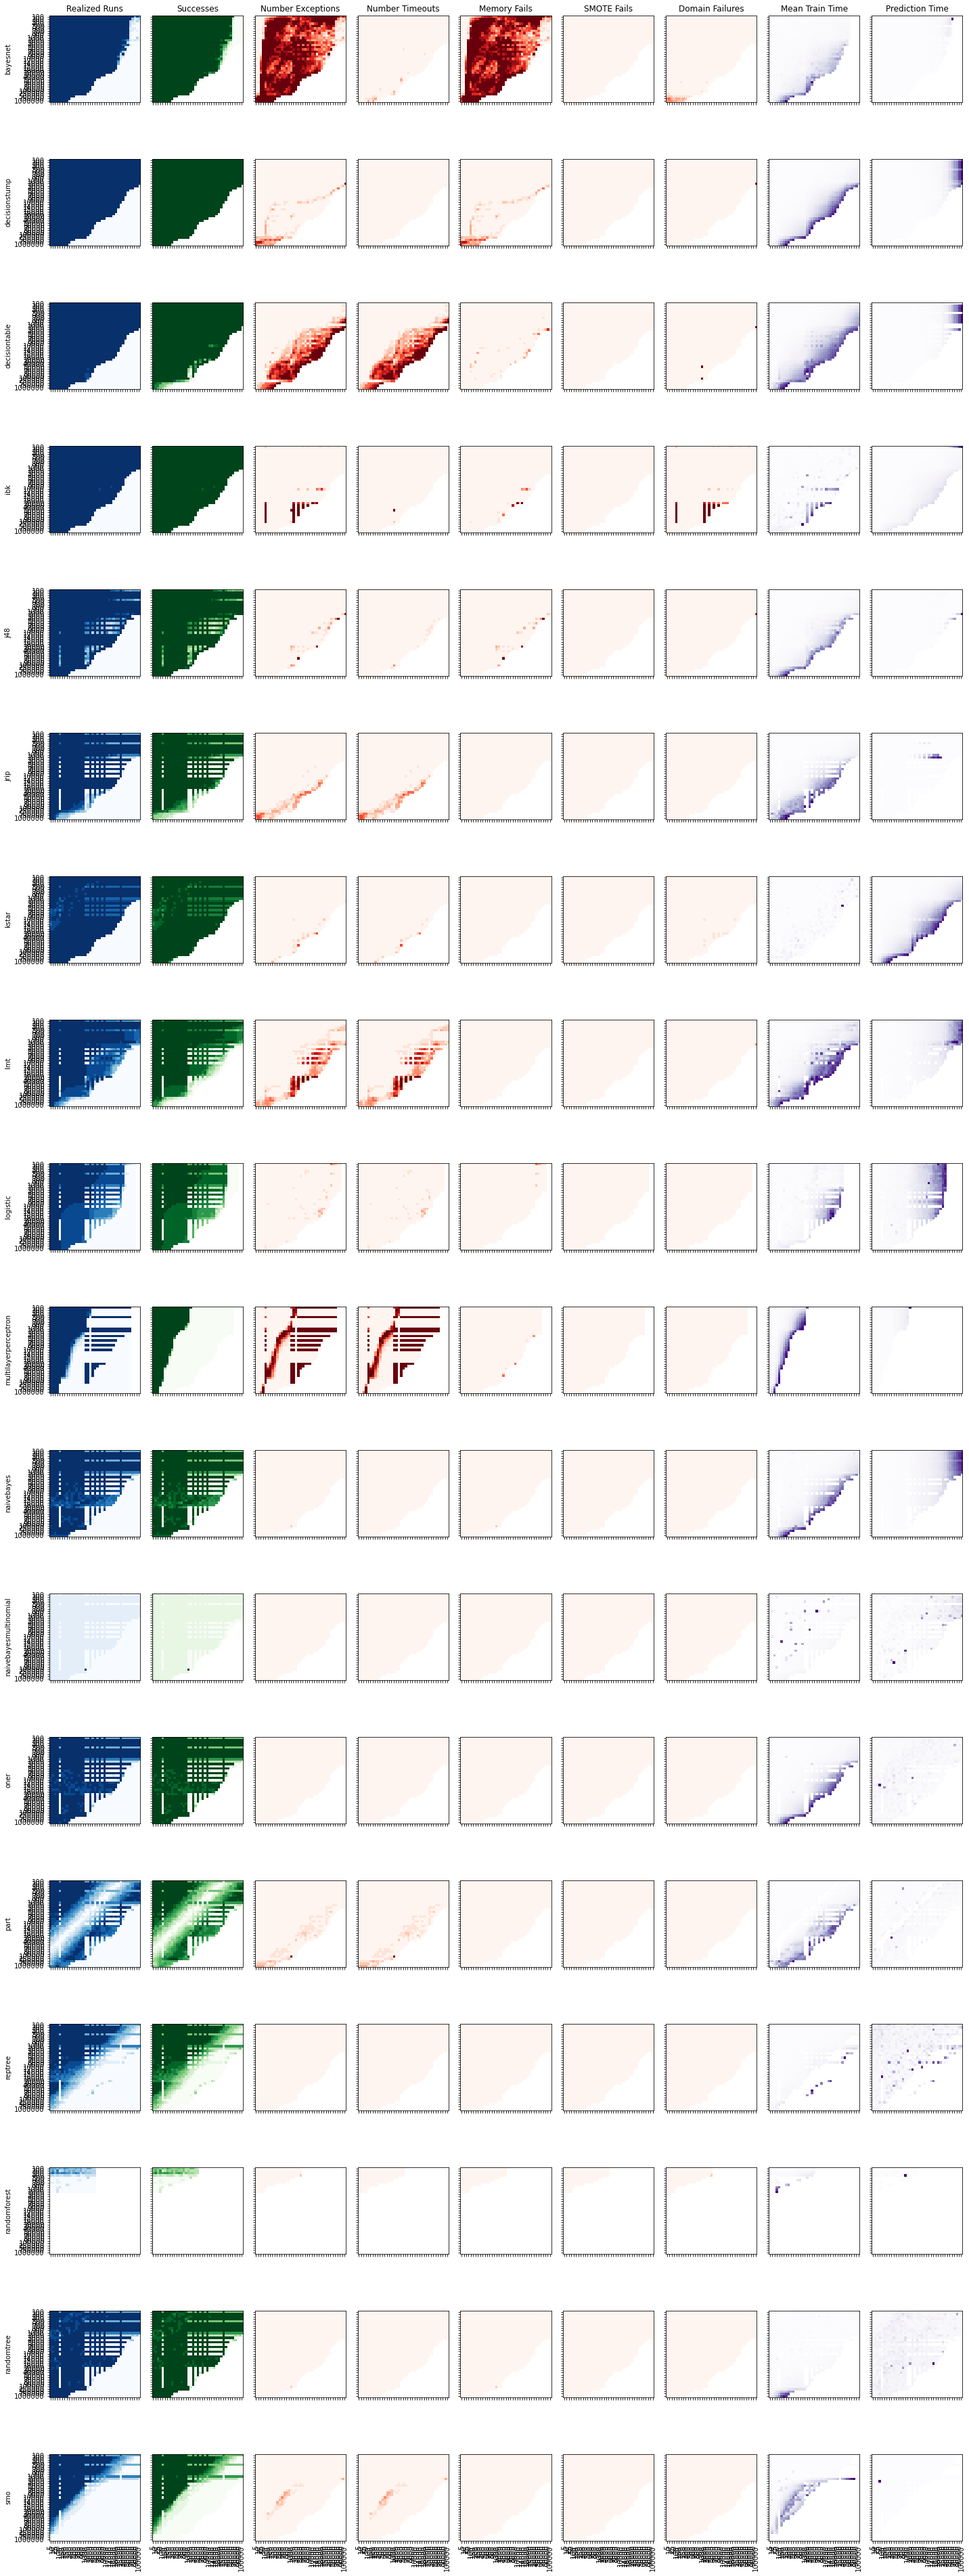

In [12]:
def plotGatheringResults(dfMap):
    fig, ax = plt.subplots(len(dfMap), 9, figsize=(20,3 * len(dfMap)), sharey=True, sharex=True)
    
    for i, algorithm in enumerate(dfMap):
    
        df = dfMap[algorithm]
        nRange = sorted(pd.unique(df["fitsize"]))
        dRange = sorted(pd.unique(df["fitattributes"]))

        M0 = np.zeros((len(nRange), len(dRange)))
        M1 = np.zeros((len(nRange), len(dRange)))
        M2 = np.zeros((len(nRange), len(dRange)))
        M3 = np.zeros((len(nRange), len(dRange)))
        M4 = np.zeros((len(nRange), len(dRange)))
        M5 = np.zeros((len(nRange), len(dRange)))
        M6 = np.zeros((len(nRange), len(dRange)))
        M7 = np.zeros((len(nRange), len(dRange)))
        M8 = np.zeros((len(nRange), len(dRange)))
        for u, numDatapoints in enumerate(nRange):
            for v, numAttributes in enumerate(dRange):

                if numDatapoints * numAttributes > 3 * 10**8:
                    M1[u, v] = M2[u, v] = M3[u, v] = M4[u, v] = M5[u, v] = M6[u, v] = M7[u, v] = M8[u, v] = np.nan
                    continue

                dfCell = df[(df["fitsize"] == numDatapoints) & (df["fitattributes"] == numAttributes)]
                numObservations = len(dfCell)
                numSuccesses = len(dfCell[dfCell["exception"].isna()])
                numExceptions = len(dfCell[dfCell["exception"].notna()])
                numTimeouts = np.count_nonzero(dfCell["exception"].notna() & dfCell["exception"].str.contains("timeout",  case=False))
                numMemoryfails = np.count_nonzero(dfCell["exception"].notna() & dfCell["exception"].str.contains("memory",  case=False))
                numSmotefails = np.count_nonzero(dfCell["exception"].notna() & dfCell["exception"].str.contains("smote",  case=False))
                numFailures = np.count_nonzero(dfCell["exception"].notna()) - numTimeouts - numMemoryfails - numSmotefails

                M0[u, v] = numObservations
                M1[u, v] = numSuccesses
                M2[u, v] = numExceptions
                M3[u, v] = numTimeouts
                M4[u, v] = numMemoryfails
                M5[u, v] = numSmotefails
                M6[u, v] = numFailures
                M7[u, v] = np.nanmean(dfCell["fittime"]) / 1000
                M8[u, v] = np.nanmean(dfCell["applicationtimeperkinstances"]) / 1000




        defaultConfig = {
            "min": 0,
            "max": 10,
            "cmap": "Reds"
        }
        configs = [{
                "min": 0,
                "max": 10,
                "cmap": "Blues",
                "title": "Realized Runs"
            },
            {
                "min": 0,
                "max": 10,
                "cmap": "Greens",
                "title": "Successes"
            },
            {
                "title": "Number Exceptions"
            },
            {
                "title": "Number Timeouts"
            },
            {
                "title": "Memory Fails"
            },
            {
                "title": "SMOTE Fails"
            },
            {
                "title": "Domain Failures"
            },
            {
                "title": "Mean Train Time",
                "min": 0,
                "max": np.nanmax(M7),
                "cmap": "Purples"
            },
            {
                "title": "Prediction Time",
                "min": 0,
                "max": np.nanmax(M8),
                "cmap": "Purples"
            }
        ]
        for j, M in enumerate([M0, M1, M2, M3, M4, M5, M6, M7, M8]):
            config = defaultConfig.copy()
            for k in configs[j]:
                config[k] = configs[j][k]
            a = ax[i][j]
            a.imshow(M, vmin = config["min"], vmax = config["max"], cmap=config["cmap"])
            a.set_xticks(range(len(dRange)))
            a.set_xticklabels(dRange, rotation=90)
            a.set_yticks(range(len(nRange)))
            a.set_yticklabels(nRange)
            if j == 0:
                a.set_ylabel(algorithm)
            if i == 0:
                a.set_title(config["title"])
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()
    plt.show()

plotGatheringResults(dfMap)

In [45]:
coredatasets

[3, 57, 741, 743, 772, 813, 903, 904, 914, 923]

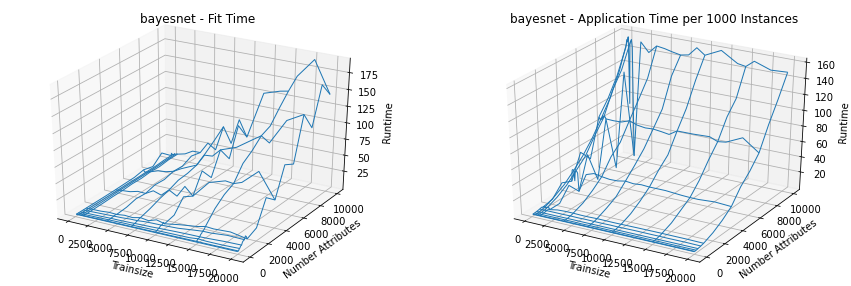

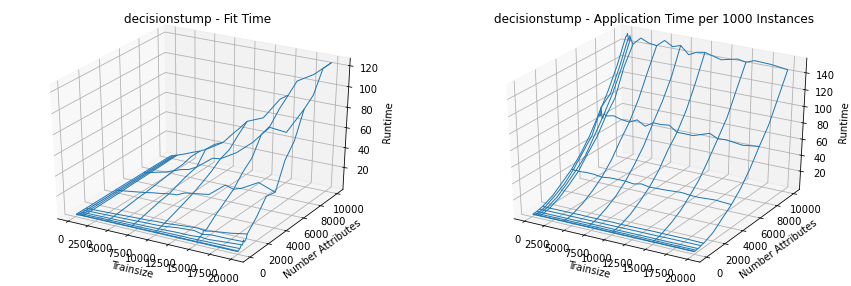

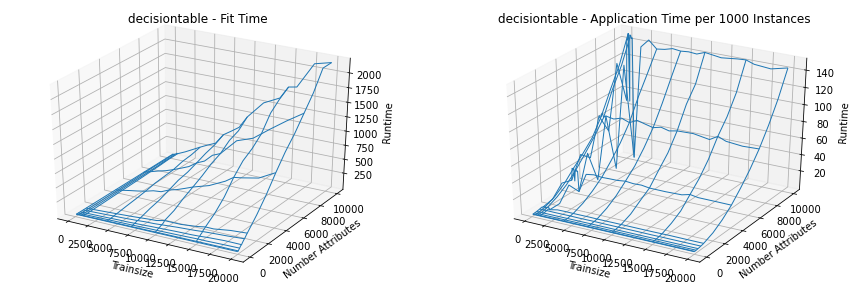

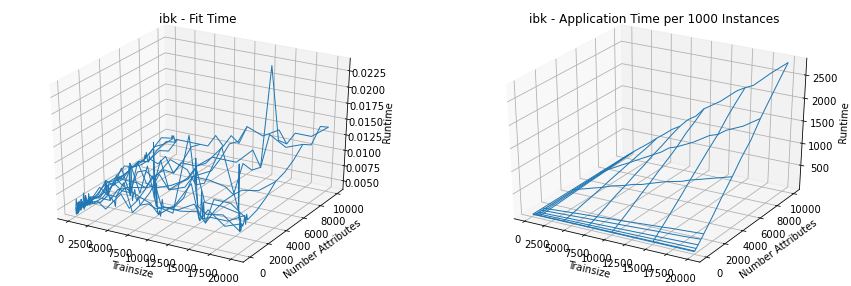

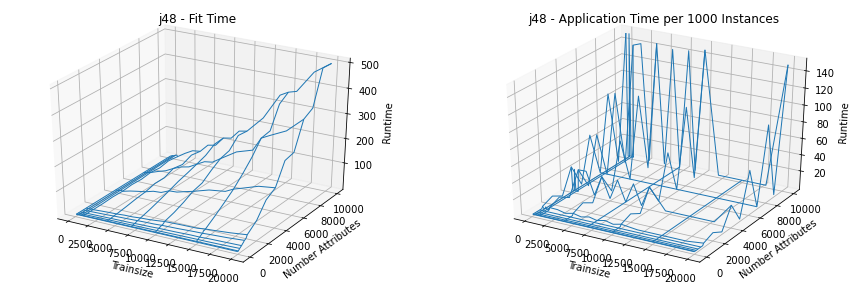

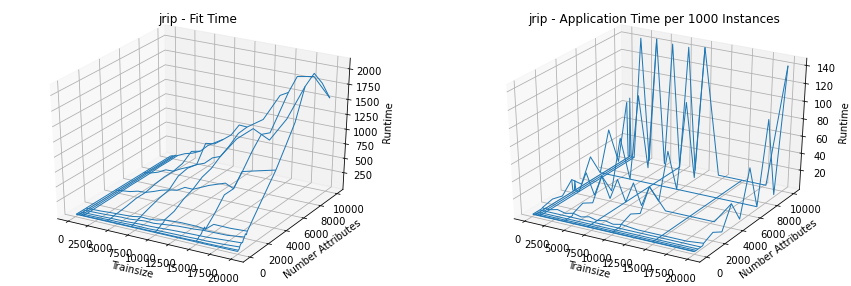

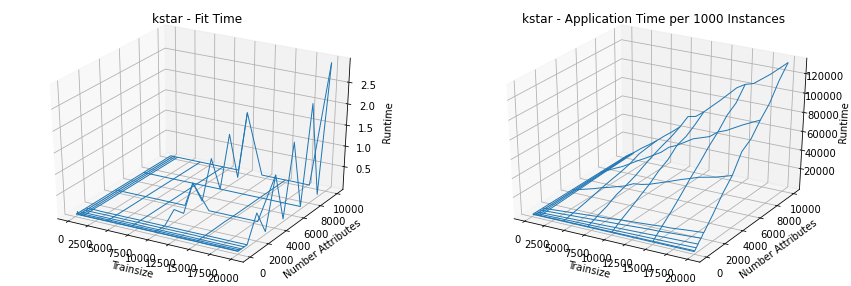

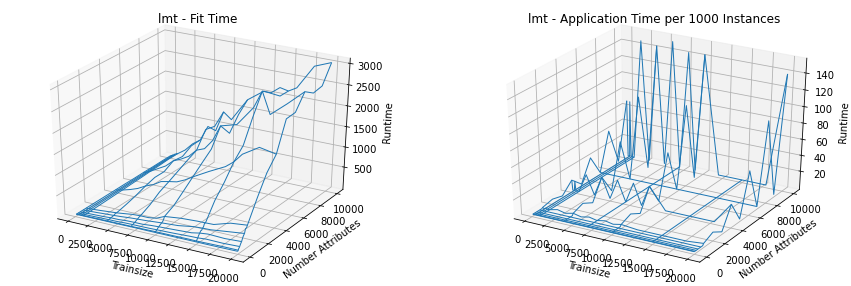

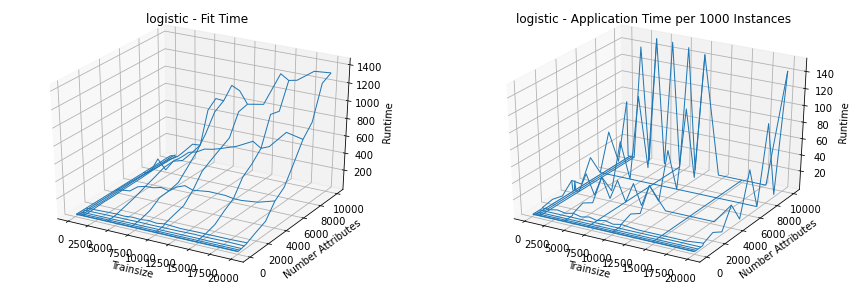

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


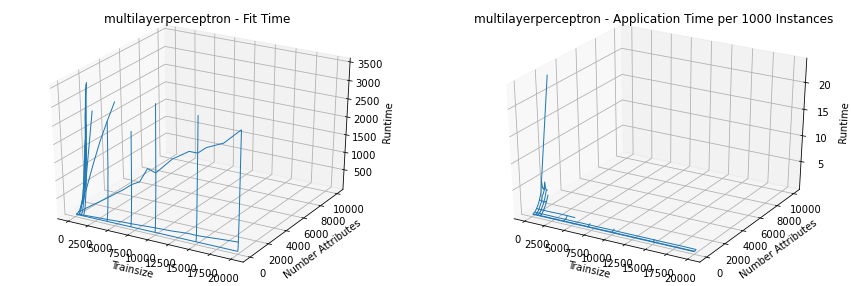

In [122]:
def plotRuntimes():
    for algorithm in dfMap:
        df = dfMap[algorithm]
        trainpoints = sorted([s for s in np.unique(df["fitsize"]) if s <= 2 * 10**4])
        attributes = sorted([s for s in np.unique(df["fitattributes"]) if s <= 10**4])
        
        traintimes = np.zeros((len(trainpoints), len(attributes)))
        dispersion_traintimes = np.zeros((len(trainpoints), len(attributes)))
        testtimes = np.zeros((len(trainpoints), len(attributes)))
        dispersion_testtimes  = np.zeros((len(trainpoints), len(attributes)))
        for i, fitsize in enumerate(trainpoints):
            for j, numatts in enumerate(attributes):
                series = df[(df["fitsize"] == fitsize) & (df["fitattributes"] == numatts)]
                traintimes[i][j] = np.nanquantile(series["fittime"], 0.5) / 1000
                dispersion_traintimes[i][j] = np.nanstd(series["fittime"])# / np.nanmean(series["fittime"])
                testtimes[i][j] = np.nanquantile(series["applicationtimeperkinstances"], 0.5) / 1000
                dispersion_testtimes[i][j] = np.nanstd(series["applicationtimeperkinstances"])# / np.nanmean(series["applicationtimeperkinstances"])
                #traintimes[i][j] = np.nanmean(series["fittime"]) / 1000
                #testtimes[i][j] = np.nanmean(series["applicationtimeperkinstances"]) / 1000

        X, Y = np.meshgrid(trainpoints, attributes)
        #adjustLimits(projection, ax)
        fig = plt.figure()
        for i, table in enumerate([traintimes, testtimes]):
            ax = fig.add_subplot(1, 2, (i + 1), projection='3d')
            fig.set_figheight(5)
            fig.set_figwidth(15)
            ax.plot_wireframe(X, Y, table.T, rstride=3, cstride=3, linewidth=1, antialiased=True)
            ax.set_xlabel('Trainsize')
            ax.set_ylabel('Number Attributes')
            ax.set_zlabel('Runtime')
            ax.set_title(algorithm + " - " + ("Fit Time" if i == 0 else "Application Time per 1000 Instances"))
            
            #ax = fig.add_subplot(1, 4, (2 * i + 2))
            #ax.imshow(dispersion_traintimes if i == 0 else dispersion_testtimes, vmax=1000)
        
        fig.savefig("plots/runtimes_" + algorithm + ".pdf")
        plt.show()
        plt.close()

plotRuntimes()

Mean IQR:  407.6153
Mean IQR:  1930.6


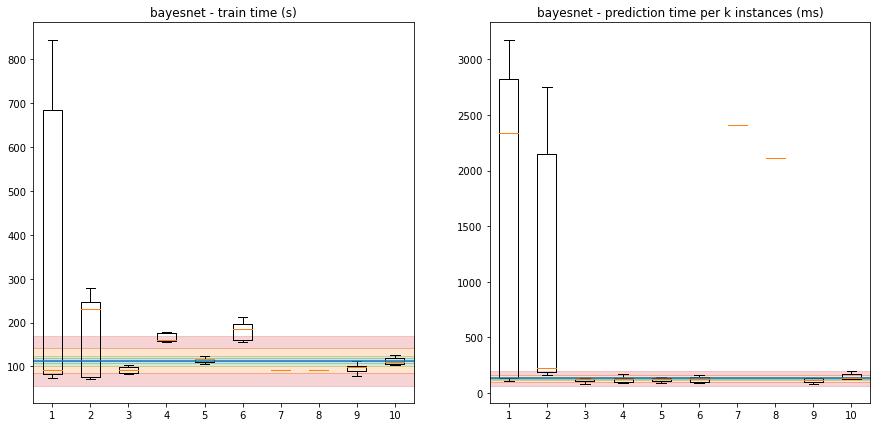

Mean IQR:  23.866300000000003
Mean IQR:  2149.5


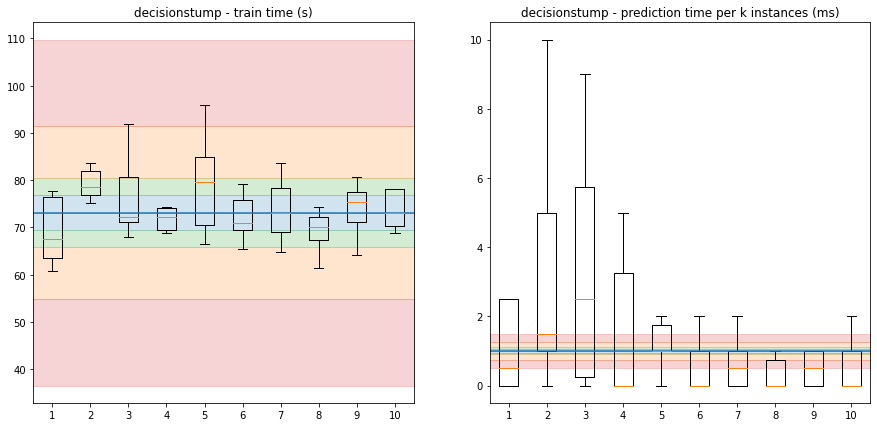

Mean IQR:  650.1701111111112
Mean IQR:  2083.0


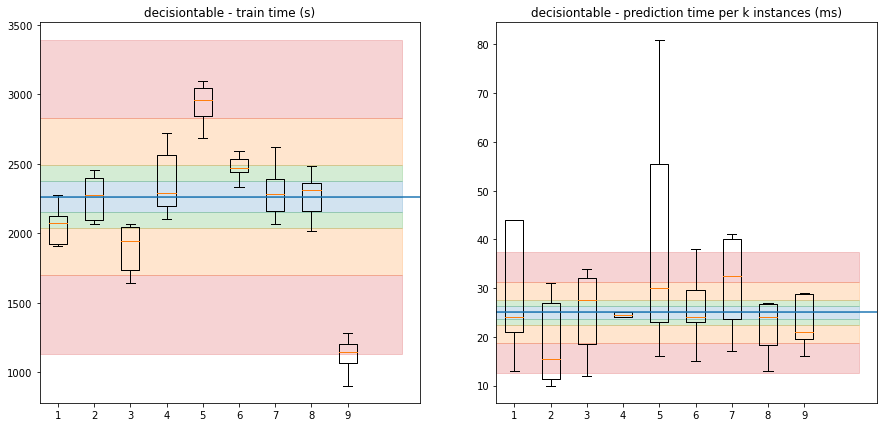

Mean IQR:  0.0
Mean IQR:  0.0


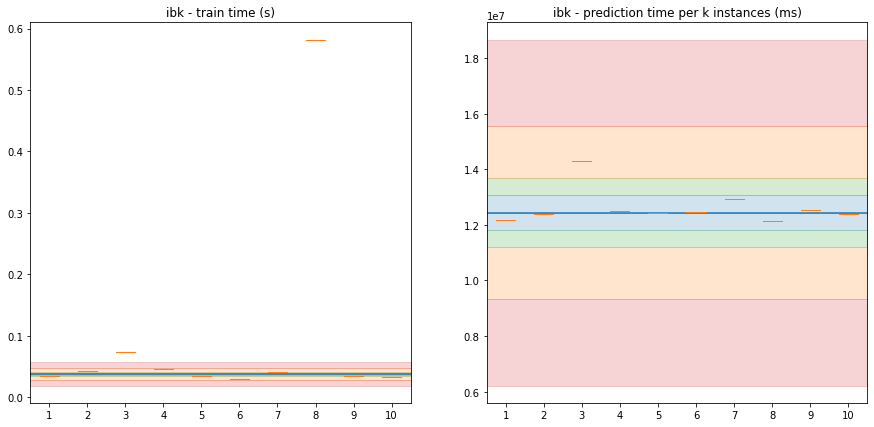

Mean IQR:  0.0
Mean IQR:  0.0


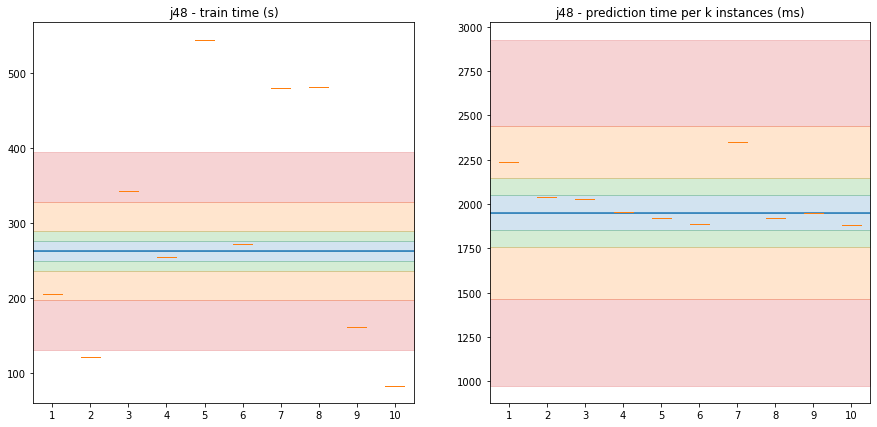

Mean IQR:  0.0
Mean IQR:  0.0


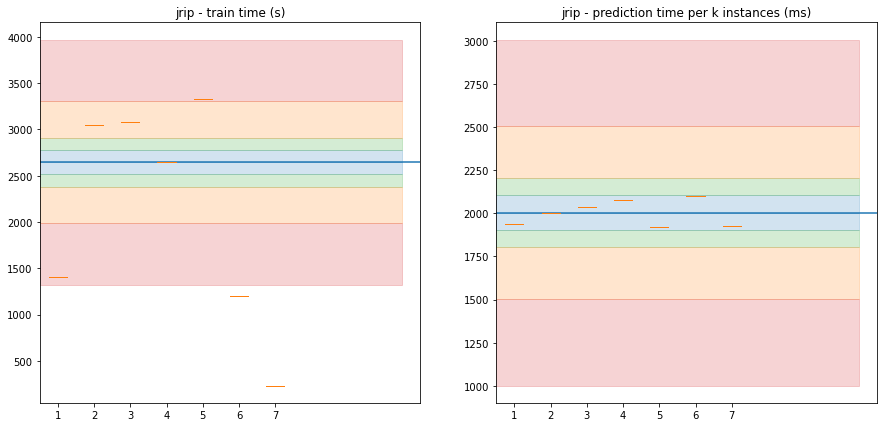

Mean IQR:  0.0
Mean IQR:  0.0


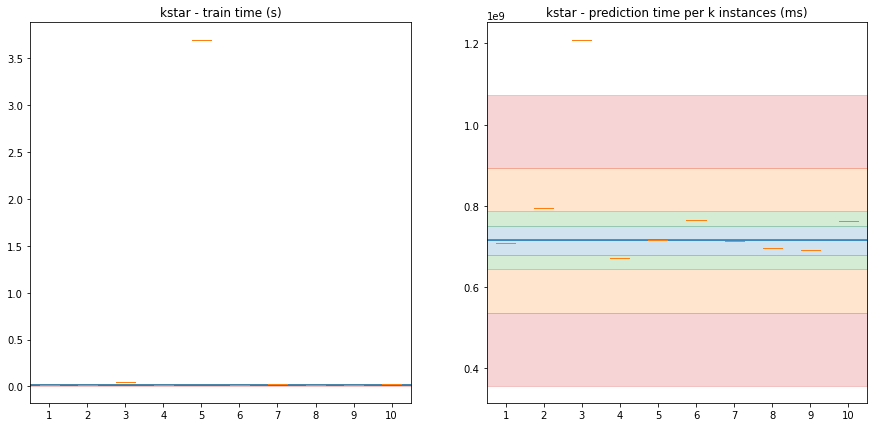

Mean IQR:  0.0
Mean IQR:  0.0


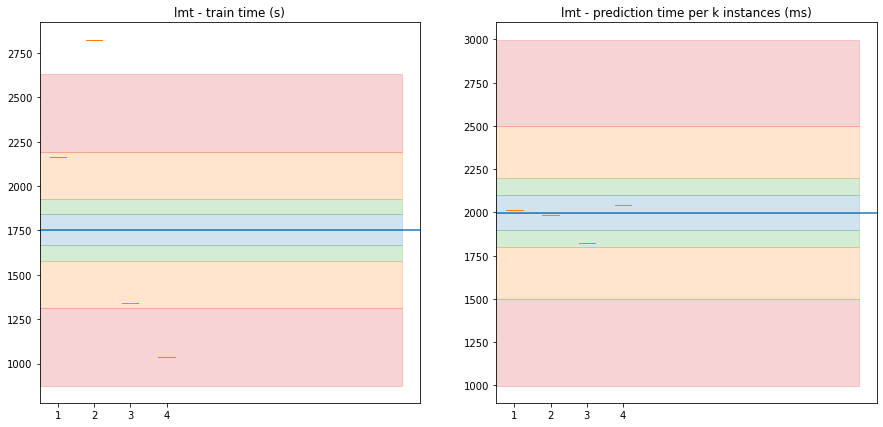

Mean IQR:  0.0
Mean IQR:  0.0


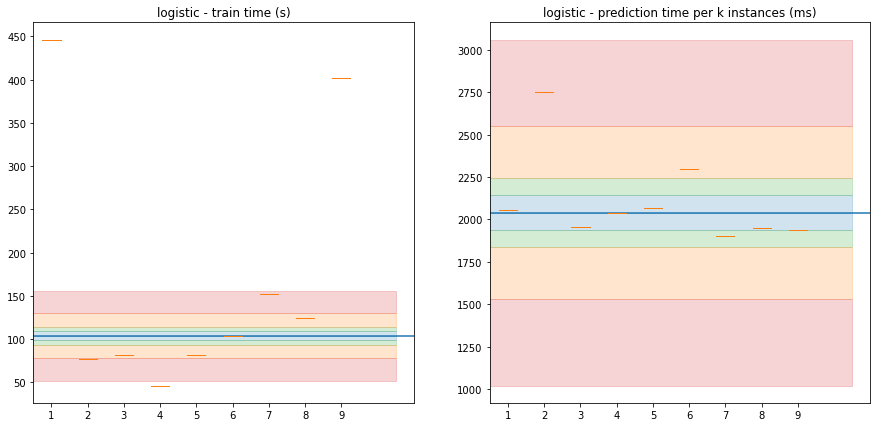

Mean IQR:  1.9254000000000002
Mean IQR:  694.7


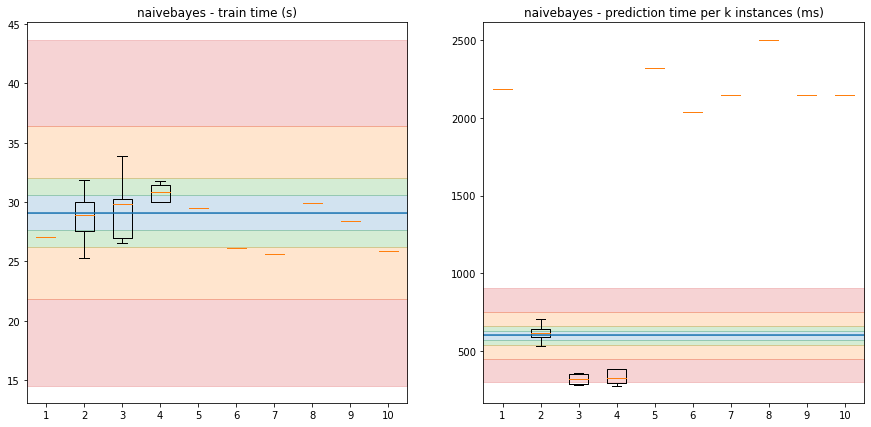

Mean IQR:  1.3150000000000002
Mean IQR:  2020.0


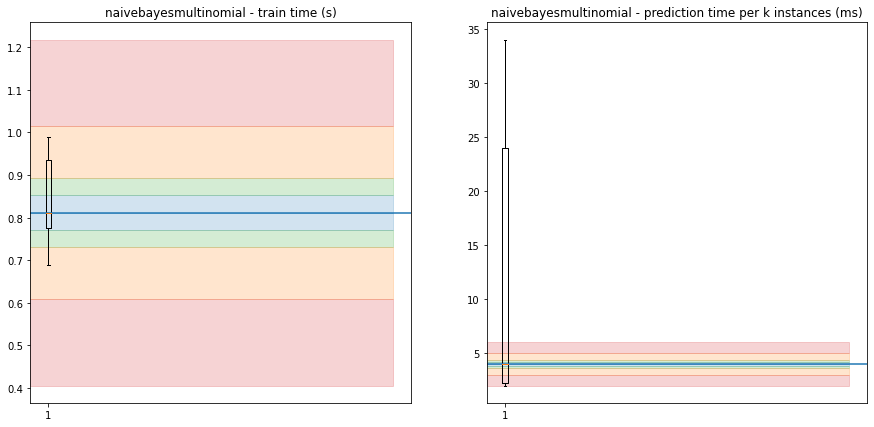

Mean IQR:  15.690700000000001
Mean IQR:  2055.8


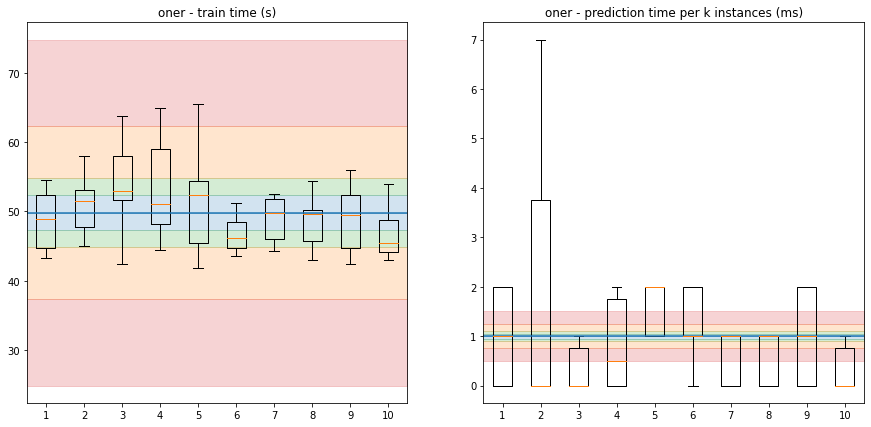

Mean IQR:  218.02285714285716
Mean IQR:  1763.142857142857


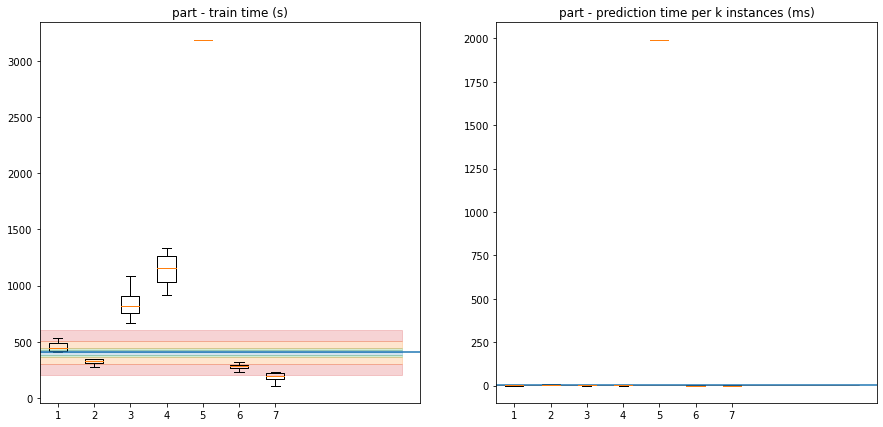

Mean IQR:  0.0
Mean IQR:  0.0


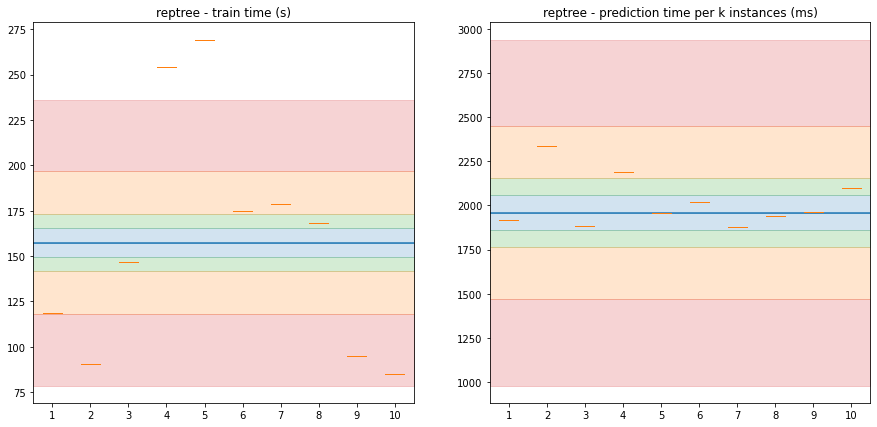

Mean IQR:  0.0
Mean IQR:  0.0


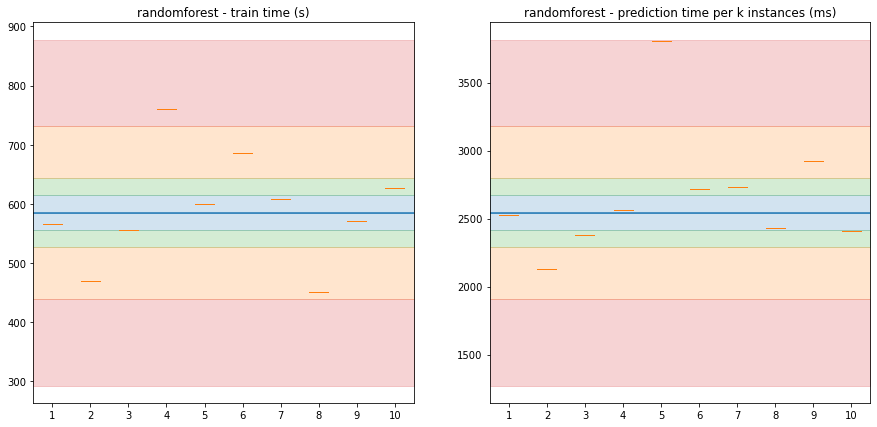

Mean IQR:  11.4198
Mean IQR:  2112.9


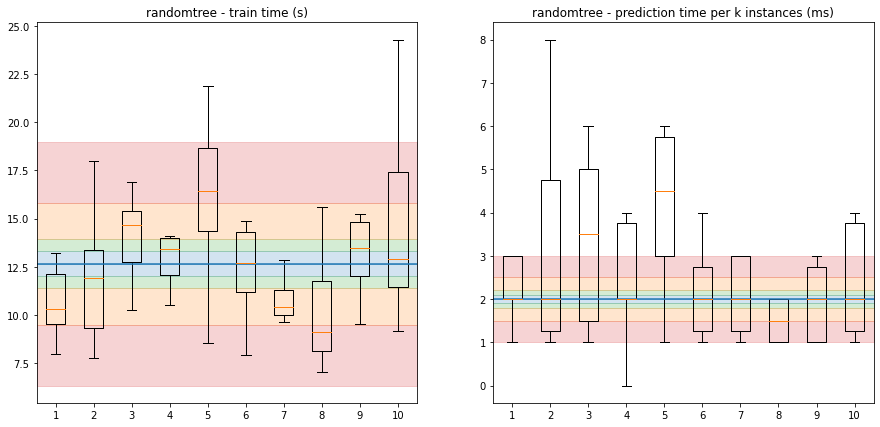

Mean IQR:  0.0
Mean IQR:  0.0


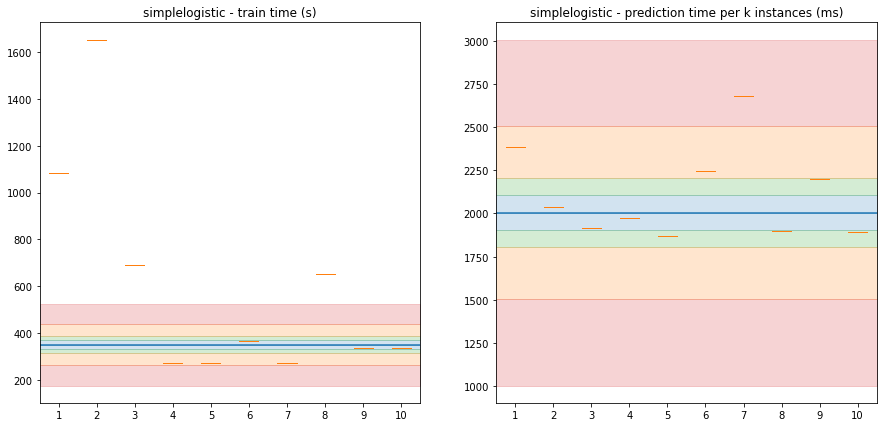

Mean IQR:  0.0
Mean IQR:  0.0


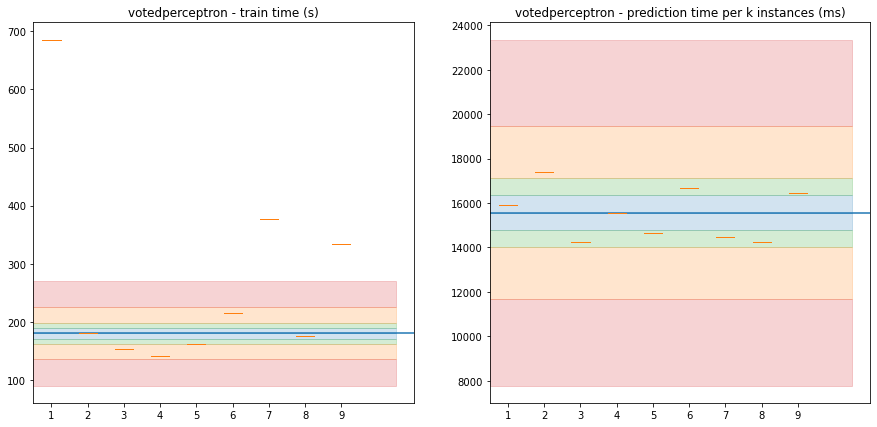

Mean IQR:  0.0
Mean IQR:  0.0


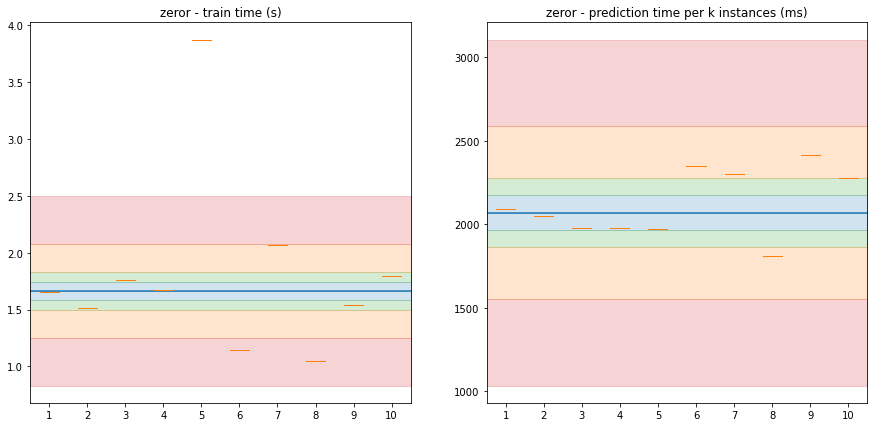

0 0


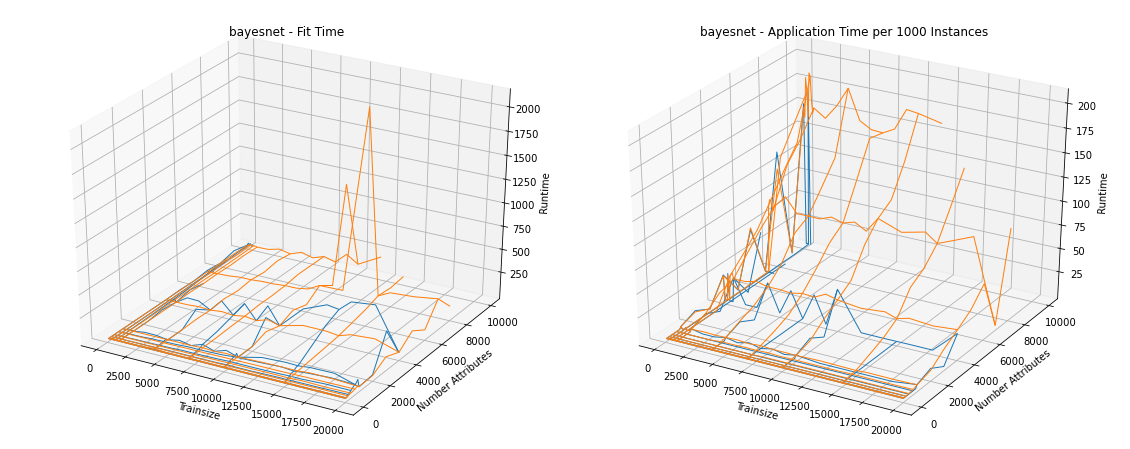

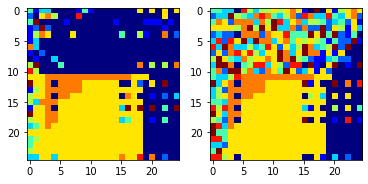

2 6


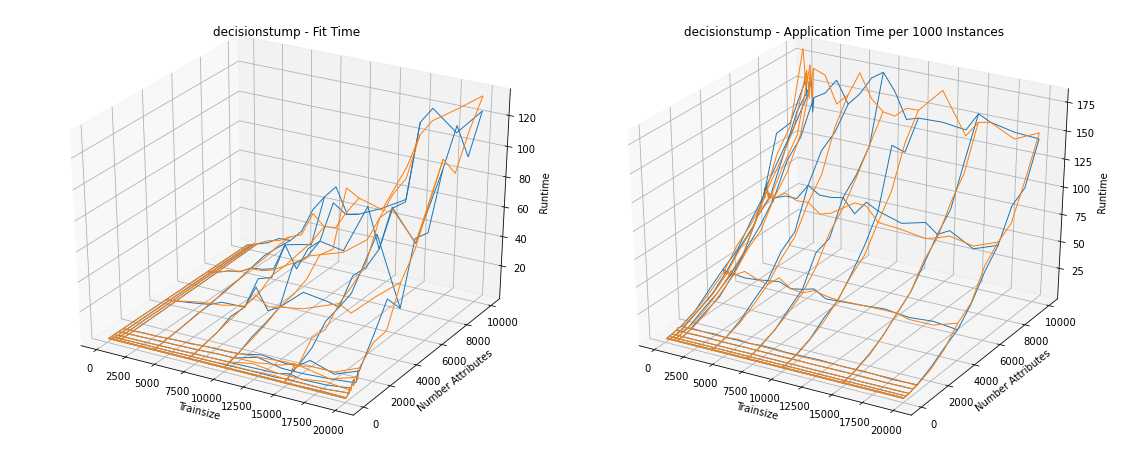

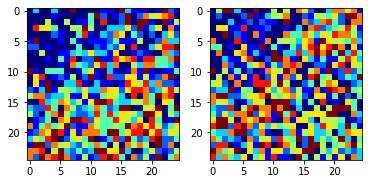

8 0


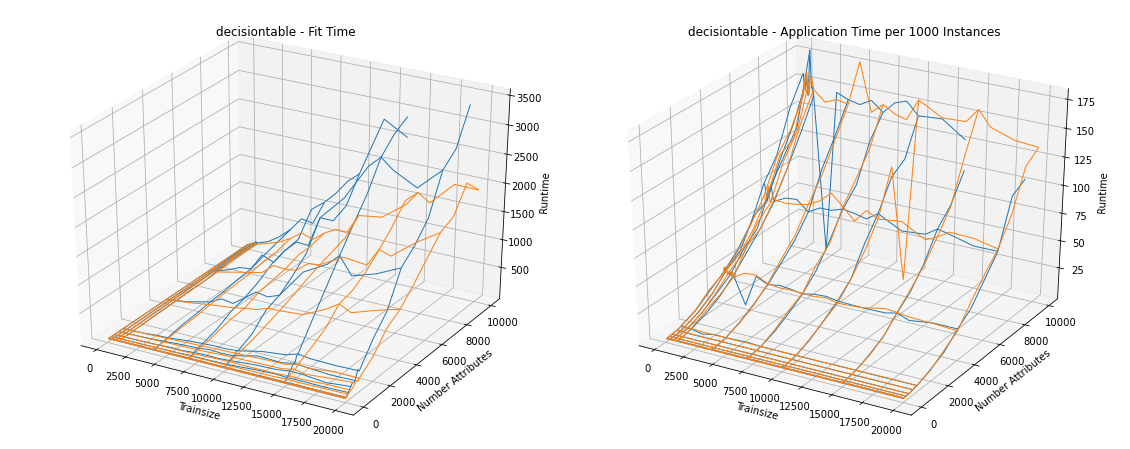

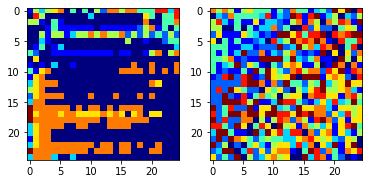

6 9


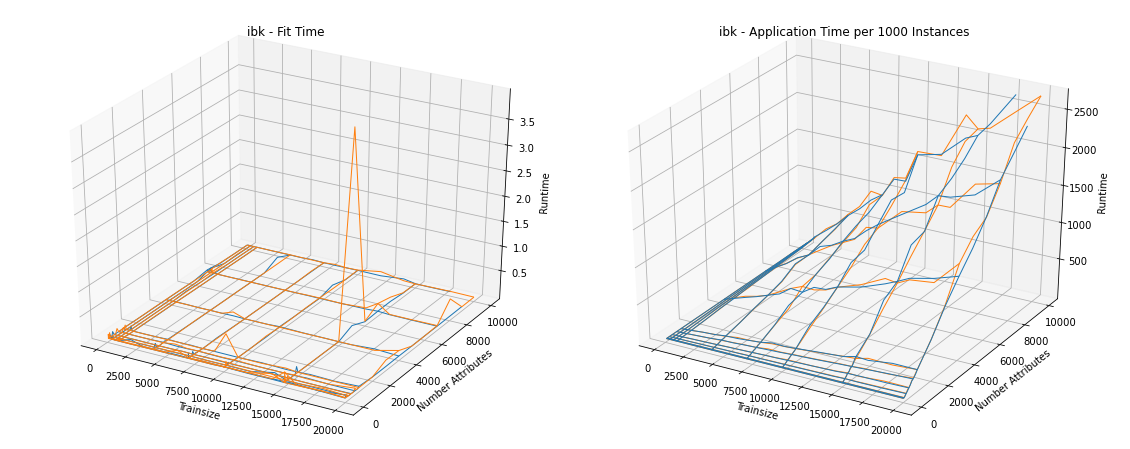

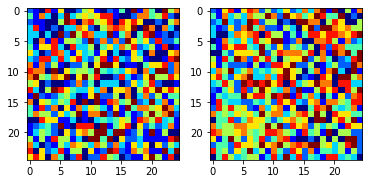

9 4


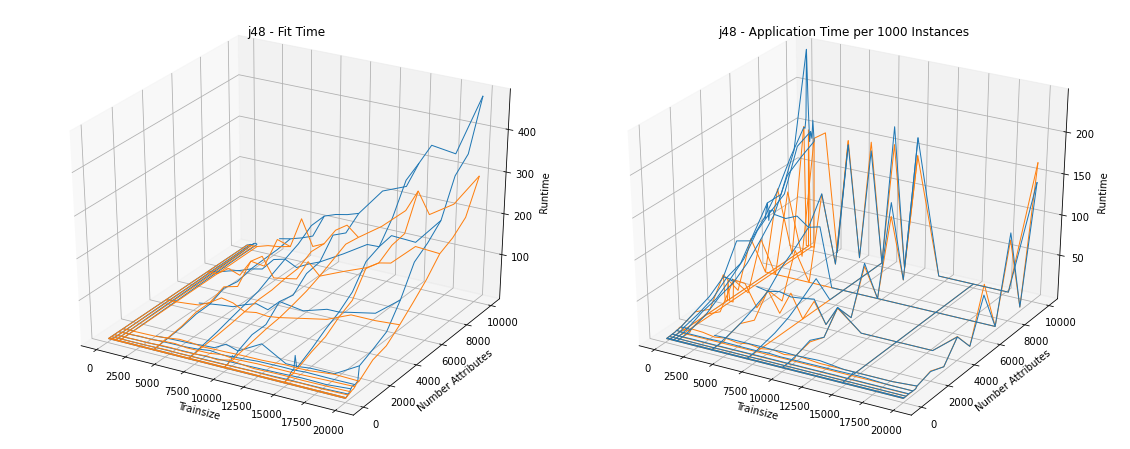

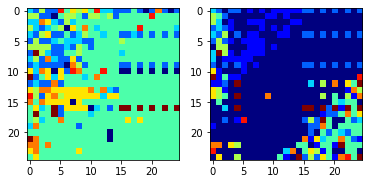

9 5


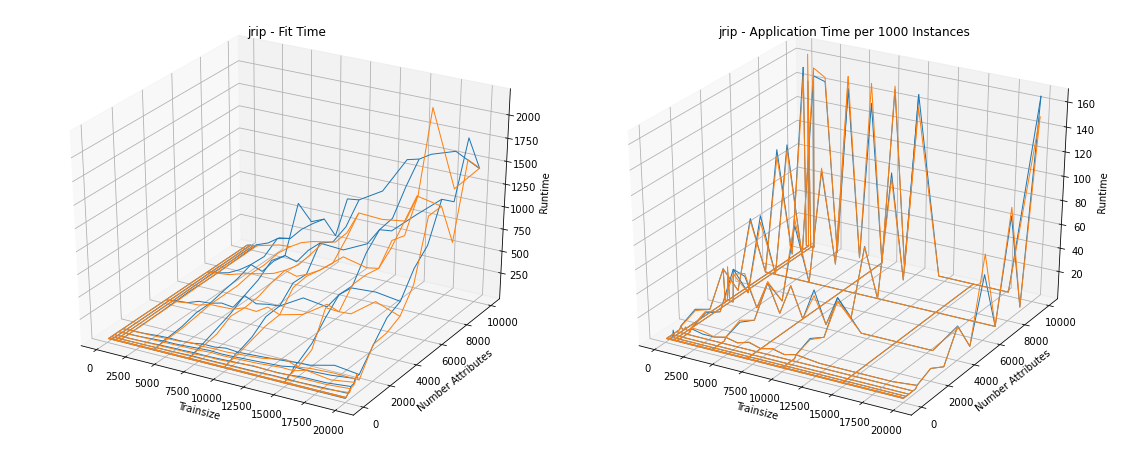

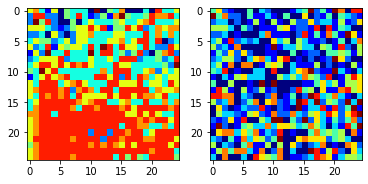

3 9


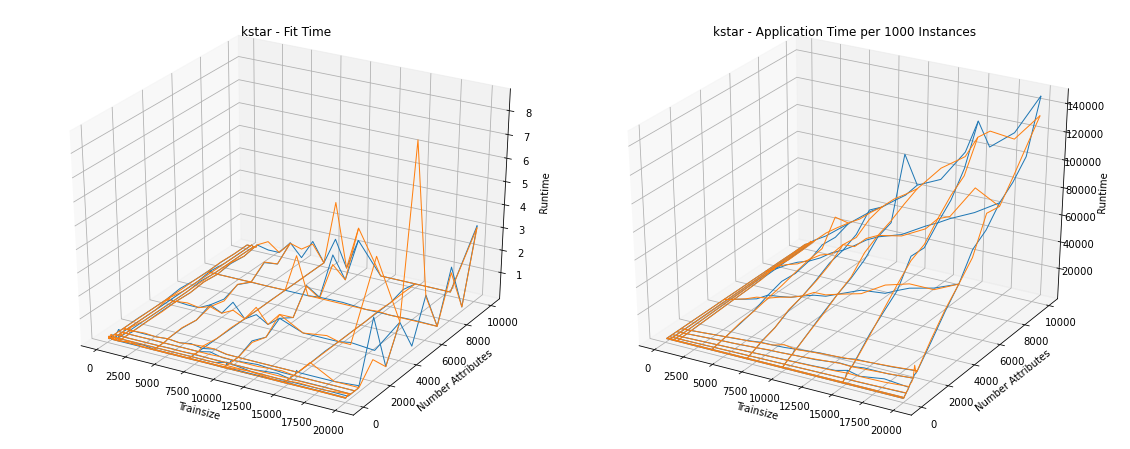

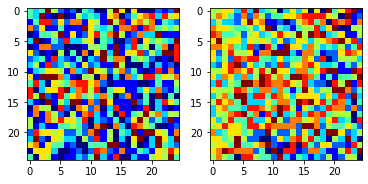

4 4


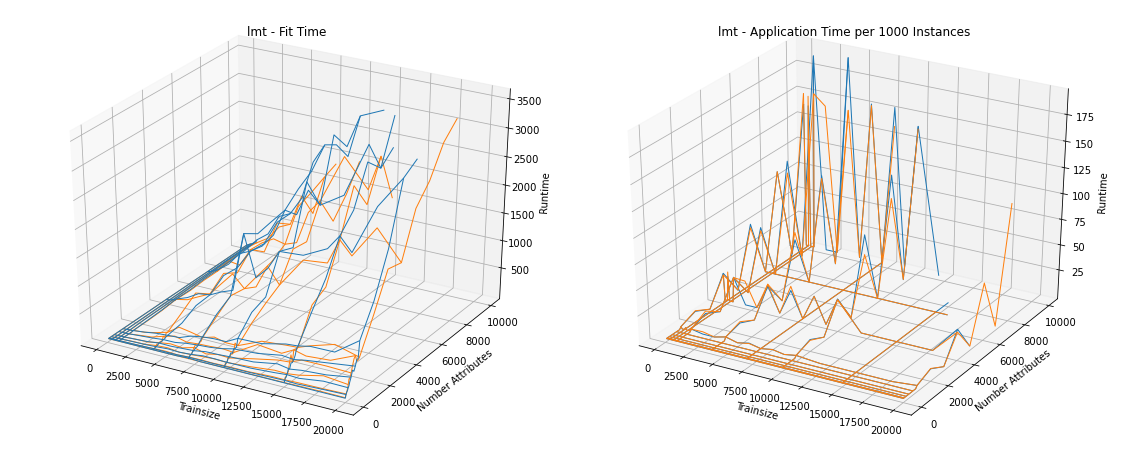

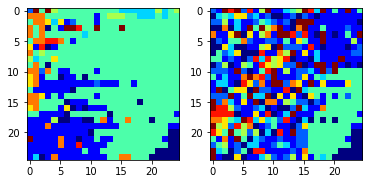

1 1


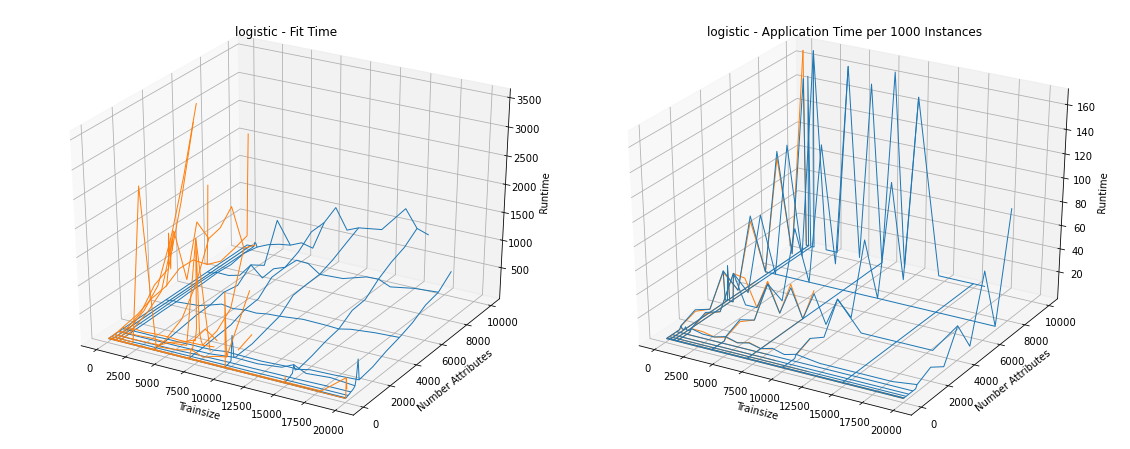

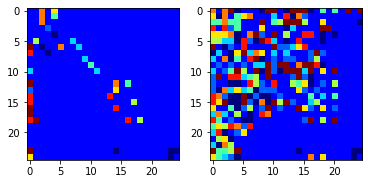

0 0


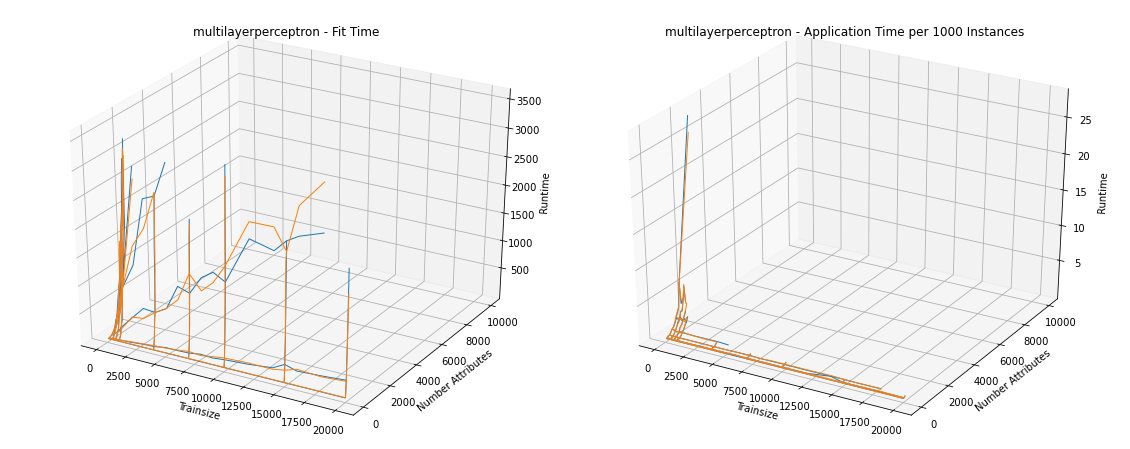

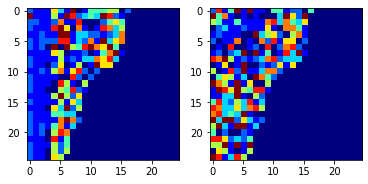

In [120]:
def plotRuntimes():
    for algorithm in dfMap:
        #if algorithm != "bayesnet":
         #   break
        dfAlgo = dfMap[algorithm]
        trainpoints = sorted([s for s in np.unique(dfAlgo["fitsize"]) if s <= 2 * 10**4])
        attributes = sorted([s for s in np.unique(dfAlgo["fitattributes"]) if s <= 10**4])
        


        X, Y = np.meshgrid(trainpoints, attributes)
        #adjustLimits(projection, ax)
        fig = plt.figure(figsize=(20, 8))
        axises = []
        fig.subplots_adjust(wspace=0, hspace=0)
        for k in range(2):
            axises.append(fig.add_subplot(1, 2, (k + 1), projection='3d'))
            fig.set_figheight(8)
            fig.set_figwidth(20)

        traintimes = np.zeros((len(coredatasets), len(trainpoints), len(attributes)))
        testtimes = np.zeros((len(coredatasets), len(trainpoints), len(attributes)))
        for l, d in enumerate(np.array(coredatasets)):
            df = dfAlgo[dfAlgo["openmlid"] == d]
            for i, fitsize in enumerate(trainpoints):
                for j, numatts in enumerate(attributes):
                    series = df[(df["fitsize"] == fitsize) & (df["fitattributes"] == numatts)]
                    traintimes[l][i][j] = np.nanquantile(series["fittime"], 0.5) / 1000
                    testtimes[l][i][j] = np.nanquantile(series["applicationtimeperkinstances"], 0.5) / 1000
        
        minIndex = np.argmin(traintimes, axis=0)[-5][-5]
        maxIndex = np.argmax(traintimes, axis=0)[-5][-5]
        print(minIndex, maxIndex)
        for l, d in enumerate(np.array(coredatasets)[[minIndex, maxIndex]]):
            for k in range(2):
                table = traintimes[l] if k == 0 else testtimes[l]
                axises[k].plot_wireframe(X, Y, table.T, rstride=3, cstride=3, linewidth=1, antialiased=True, color="C" + str(l))
        
        for k in range(2):
            ax = axises[k]
            ax.set_xlabel('Trainsize')
            ax.set_ylabel('Number Attributes')
            ax.set_zlabel('Runtime')
            #print(np.nanmax(traintimes if i == 0 else testtimes))
            #ax.set_zlim([0, np.nanquantile(traintimes if i == 0 else testtimes, 1.0)])
            ax.set_title(algorithm + " - " + ("Fit Time" if k == 0 else "Application Time per 1000 Instances"))

        plt.show()

        fig, ax = plt.subplots(1, 2)
        for k, a in enumerate(ax):
            a.imshow(np.argmax(traintimes if k == 0 else testtimes, axis=0), cmap="jet")
            
        plt.show()
        plt.close()

plotRuntimes()